<a href="https://colab.research.google.com/github/ctclumak/posts/blob/master/Machine_Learning_Classification_Models_Ad_Click_Through_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from numpy import absolute,mean, std
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("/content/Ad_click_prediction_train.csv")
df.shape

(463291, 15)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   DateTime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

session_id                     0
DateTime                       0
user_id                        0
product                        0
campaign_id                    0
webpage_id                     0
product_category_1             0
product_category_2        365854
user_group_id              18243
gender                     18243
age_level                  18243
user_depth                 18243
city_development_index    125129
var_1                          0
is_click                       0
dtype: int64

In [6]:
df.fillna(df.median(),inplace=True)
df.gender.fillna("Others",inplace=True)
df.isnull().sum()

session_id                0
DateTime                  0
user_id                   0
product                   0
campaign_id               0
webpage_id                0
product_category_1        0
product_category_2        0
user_group_id             0
gender                    0
age_level                 0
user_depth                0
city_development_index    0
var_1                     0
is_click                  0
dtype: int64

In [7]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,146115.0,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,146115.0,8.0,Female,2.0,2.0,2.0,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,146115.0,8.0,Female,2.0,2.0,2.0,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,146115.0,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,146115.0,2.0,Male,2.0,3.0,2.0,1,0


In [8]:
#change DateTime datatypes to datatime
df['DateTime'] = pd.to_datetime(df['DateTime'])
df["Year"]=df['DateTime'].dt.year
df["Month"]=df['DateTime'].dt.month
df["Day"]=df['DateTime'].dt.day
df["Weekday"]=df['DateTime'].dt.dayofweek
df["Hour"]=df['DateTime'].dt.hour
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,Year,Month,Day,Weekday,Hour
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,146115.0,10.0,Female,4.0,3.0,3.0,0,0,2017,7,2,6,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,146115.0,8.0,Female,2.0,2.0,2.0,0,0,2017,7,2,6,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,146115.0,8.0,Female,2.0,2.0,2.0,0,0,2017,7,2,6,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,146115.0,3.0,Male,3.0,3.0,2.0,1,0,2017,7,2,6,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,146115.0,2.0,Male,2.0,3.0,2.0,1,0,2017,7,2,6,0


In [9]:
df.corr().round(4)["is_click"].sort_values(ascending=False)

is_click                  1.0000
webpage_id                0.0417
campaign_id               0.0114
var_1                     0.0113
product_category_2        0.0068
user_depth               -0.0008
Hour                     -0.0031
user_id                  -0.0041
Weekday                  -0.0047
city_development_index   -0.0047
user_group_id            -0.0077
age_level                -0.0094
session_id               -0.0116
product_category_1       -0.0165
Day                      -0.0213
Year                         NaN
Month                        NaN
Name: is_click, dtype: float64

In [10]:
df["is_click"].value_counts()/len(df)

0    0.932373
1    0.067627
Name: is_click, dtype: float64

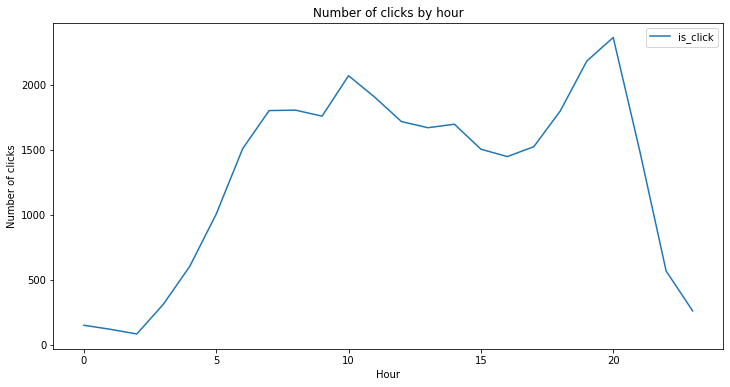

In [11]:
df.groupby('Hour').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

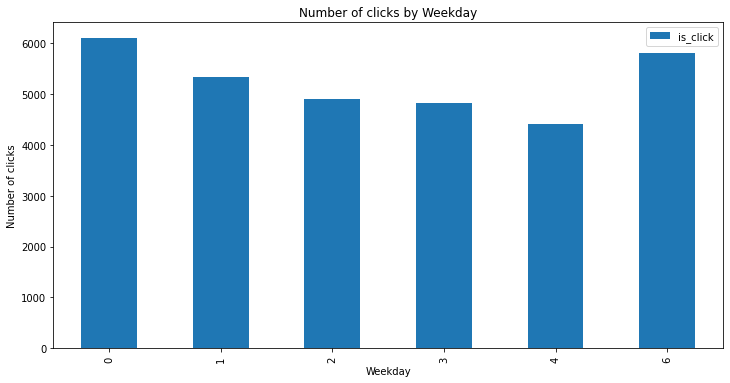

In [12]:
df.groupby('Weekday').agg({'is_click':'sum'}).plot(kind="bar", figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by Weekday');

0     6.849315
1     7.460815
2     5.273189
3     6.223734
4     5.700510
5     6.702681
6     7.282210
7     7.397823
8     7.027111
9     7.010128
10    6.777607
11    6.954296
12    6.858513
13    6.641993
14    6.530361
15    6.392927
16    6.722104
17    6.634720
18    6.622956
19    6.669113
20    6.635217
21    6.952918
22    6.651026
23    6.373626
Name: Hour, dtype: float64

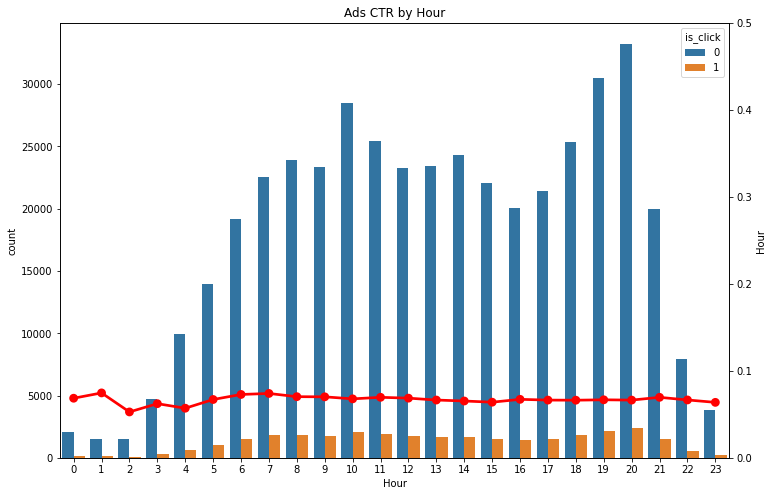

In [13]:
#Features Visualizations
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.countplot(x='Hour', data=df, hue='is_click')
plt.title('Ads CTR by Hour');
CTR = df.query('is_click == "1"')['Hour'].value_counts(sort=False)/df['Hour'].value_counts(sort=False)
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])
sns.pointplot(x=CTR.index, y=CTR, color='r', ax=ax2)
CTR*100

0    7.493242
1    7.288773
2    6.068896
3    6.205660
4    6.158173
6    7.326207
Name: Weekday, dtype: float64

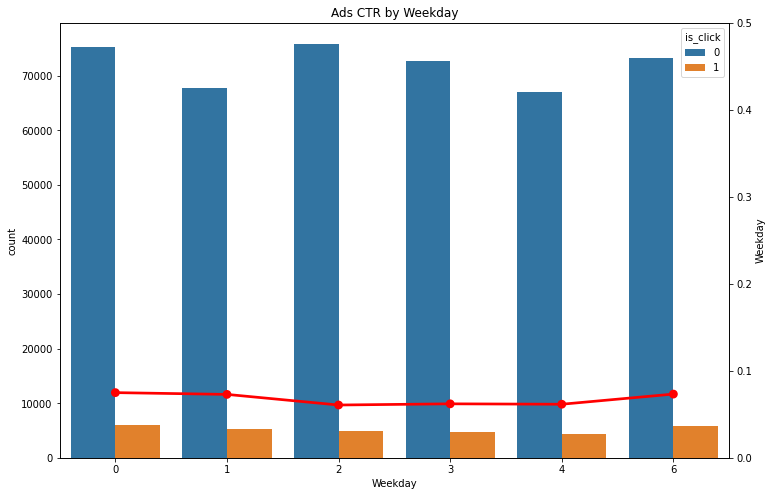

In [14]:
#Features Visualizations
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.countplot(x='Weekday', data=df, hue='is_click')
plt.title('Ads CTR by Weekday');
CTR = df.query('is_click == "1"')['Weekday'].value_counts(sort=False)/df['Weekday'].value_counts(sort=False)
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])
sns.pointplot(x=CTR.index, y=CTR, color='r', ax=ax2)
CTR*100

A    6.191930
B    5.507362
C    6.914942
D    7.181473
E    6.871154
F    4.909376
G    4.620778
H    6.985234
I    6.402348
J    9.269953
Name: product, dtype: float64

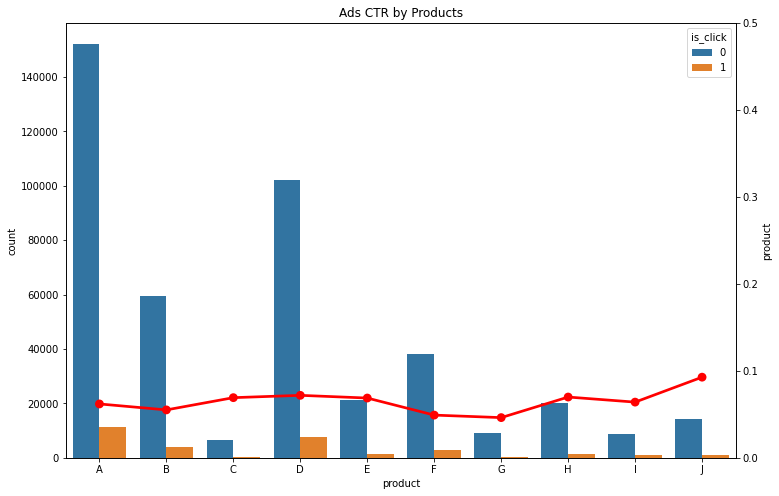

In [15]:
#Features Visualizations
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.countplot(x='product', data=df, hue='is_click')
plt.title('Ads CTR by Products');
CTR = df.query('is_click == "1"')['product'].value_counts(sort=False)/df['product'].value_counts(sort=False)
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])
sns.pointplot(x=CTR.index, y=CTR, color='r', ax=ax2)
CTR*100

1734     6.377249
6970     7.682875
11085    6.834491
13787    5.427291
28529    5.336185
45962    5.833390
51181    7.262435
53587    7.753417
60305    9.130693
Name: webpage_id, dtype: float64

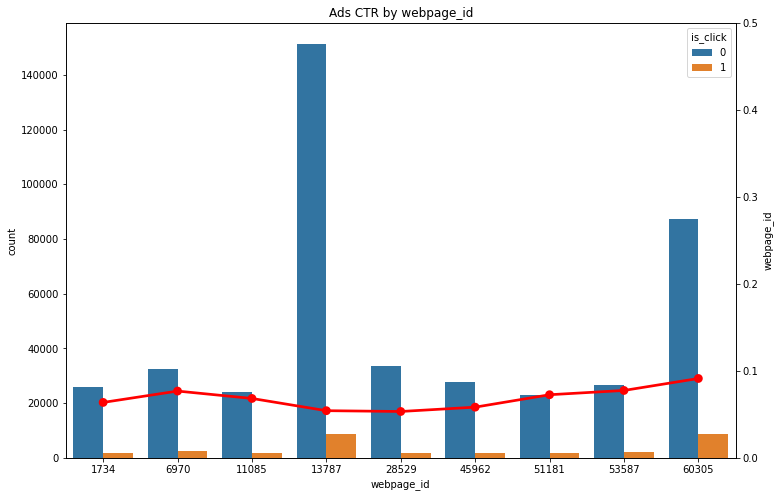

In [16]:
#Features Visualizations
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.countplot(x='webpage_id', data=df, hue='is_click')
plt.title('Ads CTR by webpage_id');
CTR = df.query('is_click == "1"')['webpage_id'].value_counts(sort=False)/df['webpage_id'].value_counts(sort=False)
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])

sns.pointplot(x=CTR.index, y=CTR, color='r', ax=ax2)

CTR*100

82320     6.377249
98970     7.682875
105960    6.834491
118601    5.336185
359520    5.861957
360936    4.521277
396664    7.262435
404347    7.753417
405490    9.130693
414149    5.833390
Name: campaign_id, dtype: float64

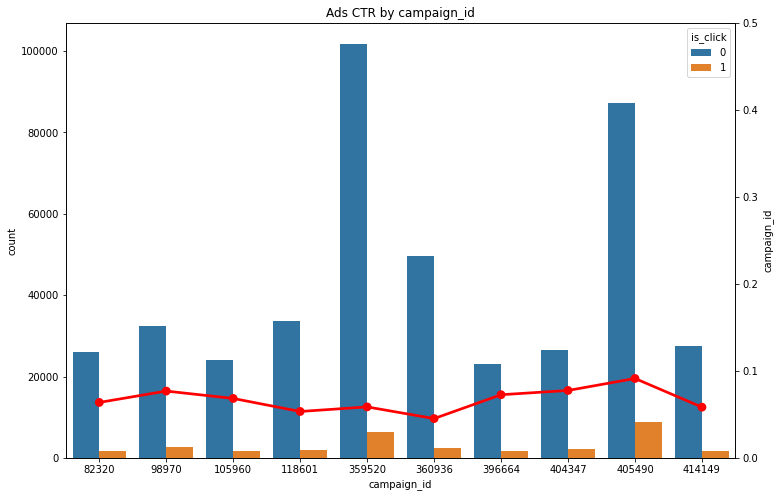

In [17]:
#Features Visualizations
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.countplot(x='campaign_id', data=df, hue='is_click')
plt.title('Ads CTR by campaign_id');
CTR = df.query('is_click == "1"')['campaign_id'].value_counts(sort=False)/df['campaign_id'].value_counts(sort=False)
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])

sns.pointplot(x=CTR.index, y=CTR, color='r', ax=ax2)
CTR*100

0.0    8.496732
1.0    7.480342
2.0    7.091937
3.0    6.505838
4.0    5.872312
5.0    7.415337
6.0    8.227619
Name: age_level, dtype: float64

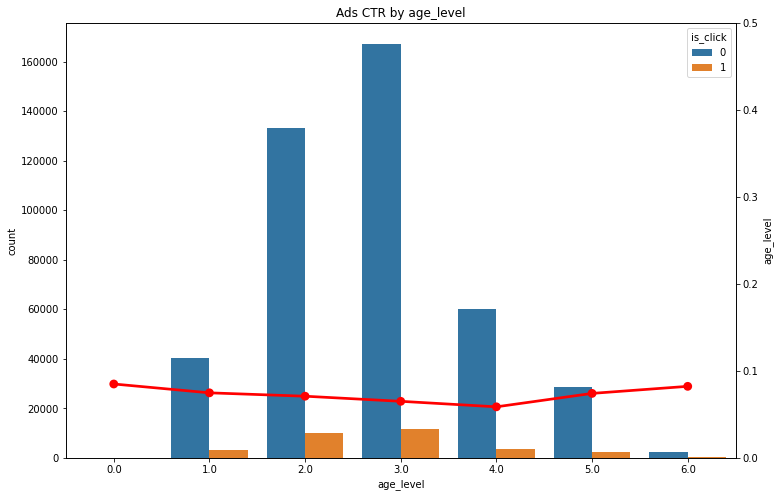

In [18]:
#Features Visualizations
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.countplot(x='age_level', data=df, hue='is_click')
plt.title('Ads CTR by age_level');
CTR = df.query('is_click == "1"')['age_level'].value_counts(sort=False)/df['age_level'].value_counts(sort=False)
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])

sns.pointplot(x=CTR.index, y=CTR, color='r', ax=ax2)
CTR*100

Female    6.444548
Male      6.794187
Others    6.983501
Name: gender, dtype: float64

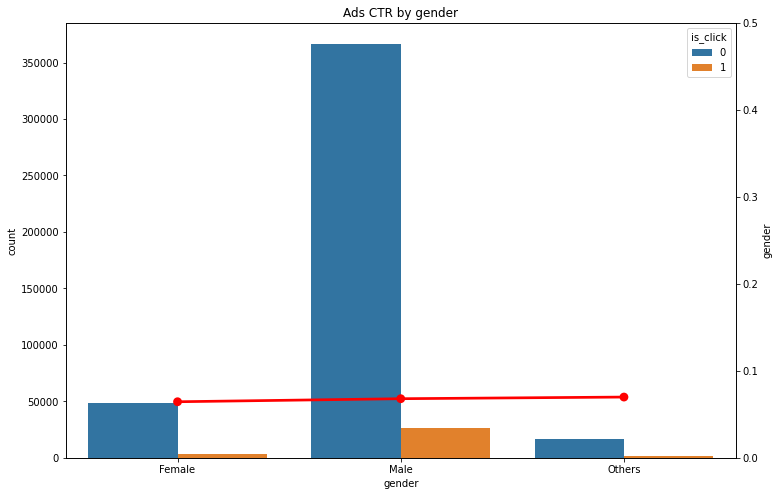

In [19]:
#Features Visualizations
fig, ax = plt.subplots(figsize=(12,8))
ax1 = sns.countplot(x='gender', data=df, hue='is_click')
plt.title('Ads CTR by gender');
CTR = df.query('is_click == "1"')['gender'].value_counts(sort=False)/df['gender'].value_counts(sort=False)
ax2 = ax1.twinx()
ax2.set_ylim([0, 0.5])

sns.pointplot(x=CTR.index, y=CTR, color='r', ax=ax2)
CTR*100

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   session_id              463291 non-null  int64         
 1   DateTime                463291 non-null  datetime64[ns]
 2   user_id                 463291 non-null  int64         
 3   product                 463291 non-null  object        
 4   campaign_id             463291 non-null  int64         
 5   webpage_id              463291 non-null  int64         
 6   product_category_1      463291 non-null  int64         
 7   product_category_2      463291 non-null  float64       
 8   user_group_id           463291 non-null  float64       
 9   gender                  463291 non-null  object        
 10  age_level               463291 non-null  float64       
 11  user_depth              463291 non-null  float64       
 12  city_development_index  463291

In [21]:
# from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_data = df[['product', 'gender']].apply(le.fit_transform)

#Extract only the columns that didnt need to be encoded
df_other_cols=df.drop(['product', 'gender'],axis=1)

#Concatenate the two dataframes : 
df = pd.concat([encoded_data, df_other_cols], axis=1)
df.head()


,product,gender,session_id,DateTime,user_id,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,age_level,user_depth,city_development_index,var_1,is_click,Year,Month,Day,Weekday,Hour
0,2,0,140690,2017-07-02 00:00:00,858557,359520,13787,4,146115.0,10.0,4.0,3.0,3.0,0,0,2017,7,2,6,0
1,2,0,333291,2017-07-02 00:00:00,243253,105960,11085,5,146115.0,8.0,2.0,2.0,2.0,0,0,2017,7,2,6,0
2,2,0,129781,2017-07-02 00:00:00,243253,359520,13787,4,146115.0,8.0,2.0,2.0,2.0,0,0,2017,7,2,6,0
3,8,1,464848,2017-07-02 00:00:00,1097446,359520,13787,3,146115.0,3.0,3.0,3.0,2.0,1,0,2017,7,2,6,0
4,2,1,90569,2017-07-02 00:01:00,663656,405490,60305,3,146115.0,2.0,2.0,3.0,2.0,1,0,2017,7,2,6,0


In [22]:
X = df.drop(["is_click","DateTime"],axis=1)
Y = df['is_click']

# #create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.16%


In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))


Accuracy: 93.23%
[[86389     0]
 [ 6270     0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     86389
           1       0.00      0.00      0.00      6270

    accuracy                           0.93     92659
   macro avg       0.47      0.50      0.48     92659
weighted avg       0.87      0.93      0.90     92659



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# Spot Check Algorithms
models = []
models.append(('Linear', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('DecisionTree', DecisionTreeClassifier(criterion='gini',min_samples_split=30,)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RandomForest', RandomForestClassifier(n_estimators=100)))
# models.append(('XGB', XGBClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
for name, model in models:
  # define the data preparation and modeling pipeline
  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  cv_results = cross_val_score(model,X_train, y_train, cv=cv, scoring='accuracy')
  cv_results = absolute(cv_results)
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))



Linear: 0.932383 (0.000996)
LDA: 0.932383 (0.000996)
DecisionTree: 0.915833 (0.001425)
KNN: 0.929345 (0.000729)
RandomForest: 0.931382 (0.001017)


In [25]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

## Chi-Square Test

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

[8.256e+00 1.542e+00 6.202e+06 1.540e+06 3.150e+06 1.260e+07 7.010e+01
 1.955e+05 4.471e+01 1.616e+01 1.682e-02 2.954e+00 3.416e+01 8.784e-25
 3.862e-27 1.359e+02 1.529e+01 9.843e+00]
[[ 140690.  858557.  359520.   13787.]
 [ 333291.  243253.  105960.   11085.]
 [ 129781.  243253.  359520.   13787.]
 [ 464848. 1097446.  359520.   13787.]
 [  90569.  663656.  405490.   60305.]]


In [27]:
# Feature Extraction with RFE

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False False False False  True False False False False False False
 False  True False False False  True]
Feature Ranking: [ 4 13 15 16 12  1  6 11  5  7  8 10 14  1  2  3  9  1]
